In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures



In [43]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2005]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [44]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [45]:
rcParams['figure.figsize'] = 9, 6

# Rolling average window setting
window_setting= 20


LME_stationary = preprocess(LME, window_setting)

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

df['lag1'] = df.lag0.shift(periods=10)
df['lag2'] = df.lag0.shift(periods=20)
df['lag3'] = df.lag0.shift(periods=30)
df['lag4'] = df.lag0.shift(periods=40)
df['lag5'] = df.lag0.shift(periods=50)

df['lag6'] = df.lag0.shift(periods=60)
df['lag7'] = df.lag0.shift(periods=70)
df['lag8'] = df.lag0.shift(periods=80)
df['lag9'] = df.lag0.shift(periods=90)
df['lag10'] = df.lag0.shift(periods=100)

df.index = df['ds']
df = df.iloc[:, 1:]

df = df.dropna()

df['y'] = df['lag0'].shift(-261)
df = df.dropna()
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
2005-06-20,-297.50,105.75,-38.75,1006.15,199.00,118.85,-180.90,132.85,1102.30,619.90,-12.25,-1325.50
2005-06-21,-740.25,-615.50,123.00,1473.65,23.50,-542.65,-388.90,259.85,429.40,1019.25,3.25,-211.00
2005-06-22,-1031.00,-765.25,237.25,1238.15,-75.00,-828.15,-204.65,259.50,195.50,734.95,29.95,-633.50
2005-06-23,-1667.25,-446.25,234.50,1458.65,120.00,-529.40,56.85,51.00,827.35,566.60,203.50,-813.75
2005-06-24,-1890.75,-533.50,-6.00,1015.25,474.25,-85.50,-251.40,514.90,764.10,905.85,-88.75,98.75


## Linear Regression

IMPORTANT NOTE TO SELF: 
For smoothing using moving average, must RESCALE output predictions using inputs!! 

SECOND NOTE 2 SELF: 
for training/fitting/testing set... 

MODEL FOR DEPLOYMENT: 
Train a model that uses values from a year ago or OLDER to predict values and rescale according to moving averages... 



In [46]:
X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10']]
y= df['y']

X_test = X.loc['2017-10-14':,:]
y_test = y['2017-10-14':]

X_train = X.loc[:'2017-10-14', :]
y_train = y[:'2017-10-14']


X_train.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
ds,,,,,,,,,,,
2005-06-20,-297.50,105.75,-38.75,1006.15,199.00,118.85,-180.90,132.85,1102.30,619.90,-12.25
2005-06-21,-740.25,-615.50,123.00,1473.65,23.50,-542.65,-388.90,259.85,429.40,1019.25,3.25
2005-06-22,-1031.00,-765.25,237.25,1238.15,-75.00,-828.15,-204.65,259.50,195.50,734.95,29.95
2005-06-23,-1667.25,-446.25,234.50,1458.65,120.00,-529.40,56.85,51.00,827.35,566.60,203.50
2005-06-24,-1890.75,-533.50,-6.00,1015.25,474.25,-85.50,-251.40,514.90,764.10,905.85,-88.75


In [47]:
# NOTE: Fix if overlapping
#X_train = X.loc[:'2017-10-07', :]
#y_train = y[:'2017-10-07']


In [21]:
regressor = LinearRegression()

regressor.fit(X_train, y_train)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index


# y_pred = y_pred.reindex(X_test.index)

[-0.0740322  -0.06988447  0.01048743  0.00326602 -0.06491282 -0.05372041
  0.02059081  0.07330407 -0.03842979 -0.04026605  0.06763686]


## Back to Scale before Performance Analysis

In [22]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = []
for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))
    unscaled.append(unscaled_result)

unscaled = pd.Series(unscaled)
unscaled = unscaled
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]



for key, item in y_pred_train.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

y_train_unscaled = pd.Series(original_tail)
y_train_unscaled = y_train_unscaled[window_setting:]
y_train_unscaled.index = y_train.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index
original_y.head()



ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64

In [23]:
LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = []
for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))
    unscaled.append(unscaled_result)

unscaled = pd.Series(unscaled)
unscaled = unscaled
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]



for key, item in y_pred_train.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

y_train_unscaled = pd.Series(original_tail)
y_train_unscaled = y_train_unscaled[window_setting:]
y_train_unscaled.index = y_train.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index
original_y.head()



ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64

In [24]:
# Sanity check for unscaling! 

LME_shifted[LME_shifted.index=='2017-10-16']


#LME[LME.index=='2018-10-31']

Unnamed: 1
2017-10-16    12516.5
Freq: B, Name: Cash Price ($/MT), dtype: float64

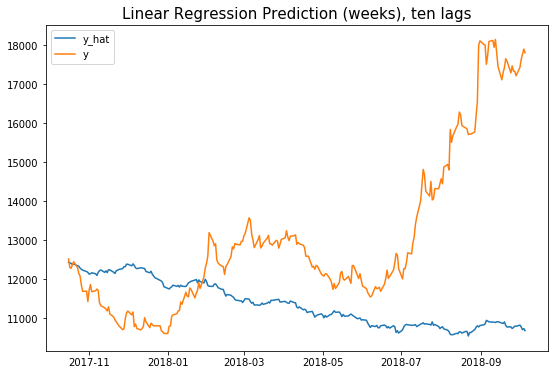

Mean Absolute Error: 2152.9942057202247
Mean Squared Error: 8796308.162360247
Root Mean Squared Error: 2965.8570704537074


In [25]:
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']


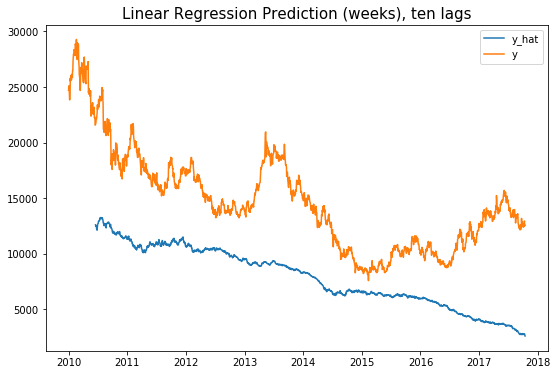

Mean Absolute Error: 2152.9942057202247
Mean Squared Error: 8796308.162360247
Root Mean Squared Error: 2965.8570704537074


In [26]:
original_y_train = LME_shifted.loc[:'2017-10-14']
plt.plot(y_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Linear Regression Prediction (weeks), ten lags', fontsize=15)

plt.show()

         
         
print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))




In [55]:
original_y_train

NameError: name 'original_y_train' is not defined

# Other Kinds of Regression

Grid Search for RIDGE Regression


{'alpha': 1e-05}
Mean Absolute Error: 1466.2306955839954
Mean Squared Error: 4551049.4881527955
Root Mean Squared Error: 2133.318890403588

{'alpha': 0.0001}
Mean Absolute Error: 1466.230695475528
Mean Squared Error: 4551049.487418845
Root Mean Squared Error: 2133.3188902315674

{'alpha': 0.001}
Mean Absolute Error: 1466.2306943920921
Mean Squared Error: 4551049.480070574
Root Mean Squared Error: 2133.3188885093045

{'alpha': 0.01}
Mean Absolute Error: 1466.2306835710353
Mean Squared Error: 4551049.406761107
Root Mean Squared Error: 2133.3188713272816

{'alpha': 0.1}
Mean Absolute Error: 1466.2305752269817
Mean Squared Error: 4551048.671942886
Root Mean Squared Error: 2133.3186991030866

{'alpha': 1}
Mean Absolute Error: 1466.2294908227186
Mean Squared Error: 4551041.295850999
Root Mean Squared Error: 2133.316970318991

Ridge CV Results
{'alpha': 1e-05} 1466.2306955839954
{'alpha': 0.0001} 1466.230695475528
{'alpha': 0.001} 1466.2306943920921
{'alpha': 0.01} 1466.2306835710353
{'alpha

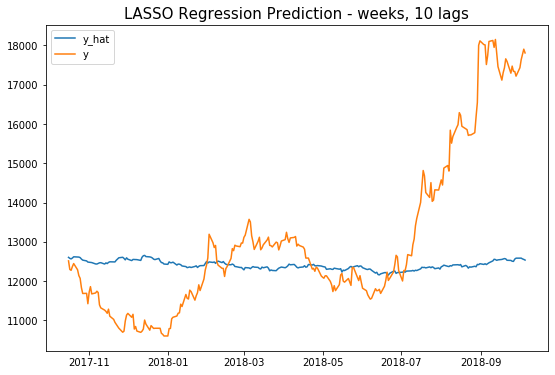

In [174]:
from sklearn import linear_model

params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                            })

cv_results = {}

for params in params1:

    regressor = linear_model.Lasso(**params, random_state=1)

    print()
    print(params)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    # y_pred = y_pred.reindex(X_test.index)

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item + rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item + rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(params)] = mae

    # To find the best/optimal parameters

    '''Calculates maximum test accuracy value and parameters'''
    #min_test_accuracy, min_parameters = 0, 0
    min_test_accuracy = 3000
    for key, value in cv_results.items():
        if value < min_test_accuracy:
            min_test_accuracy = value
            min_parameters = key
            
print()
print('Ridge CV Results')
for key, value in cv_results.items():
    print(key, value)

print()
print('Best Results:')
if min_test_accuracy==3000:
    print('error')
else:
    print('Minimum Test MAE: ', min_test_accuracy)
print('Best Parameters: ', min_parameters)
print()

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('LASSO Regression Prediction - weeks, 10 lags', fontsize=15)

plt.show()


K:  1
Mean Absolute Error: 1911.7043115055722
Mean Squared Error: 6000754.557700663
Root Mean Squared Error: 2449.643761386676

K:  3
Mean Absolute Error: 1241.1852085203466
Mean Squared Error: 2398039.1399975917
Root Mean Squared Error: 1548.5603443190685

K:  5
Mean Absolute Error: 1273.9343347303984
Mean Squared Error: 2522709.2491801274
Root Mean Squared Error: 1588.303890689728

K:  7
Mean Absolute Error: 1277.8361493071038
Mean Squared Error: 2573911.901160505
Root Mean Squared Error: 1604.3415787046426

K:  9
Mean Absolute Error: 1213.5386498988053
Mean Squared Error: 2262523.0205701953
Root Mean Squared Error: 1504.1685479261275

K:  11
Mean Absolute Error: 1162.1370394846256
Mean Squared Error: 2028764.2246414023
Root Mean Squared Error: 1424.3469467237967

K:  13
Mean Absolute Error: 1159.7121237309098
Mean Squared Error: 2023735.1169715873
Root Mean Squared Error: 1422.580443058173

K:  15
Mean Absolute Error: 1143.4697609804807
Mean Squared Error: 1946995.881932293
Root Me

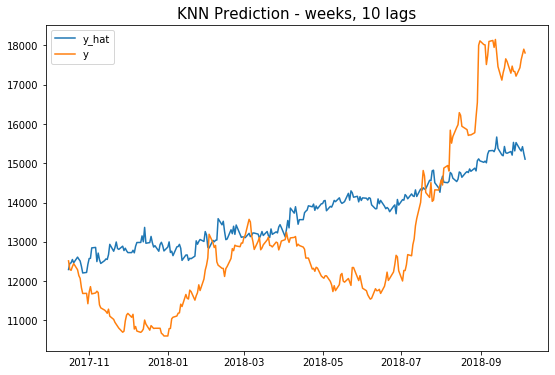

{'1': 1911.7043115055722, '3': 1241.1852085203466, '5': 1273.9343347303984, '7': 1277.8361493071038, '9': 1213.5386498988053, '11': 1162.1370394846256, '13': 1159.7121237309098, '15': 1143.4697609804807, '17': 1152.7900450166705, '19': 1195.0211049079603, '21': 1263.1071636548513, '23': 1269.105014614988, '25': 1294.057087708039, '27': 1347.390632871429, '29': 1375.060611210232, '31': 1398.0597482695414, '33': 1364.2726050875035, '35': 1364.976999799019, '37': 1378.3143586522924, '39': 1367.9444083312403, '41': 1366.8013140132239, '43': 1369.1542026327509, '45': 1386.1890905703315, '47': 1381.255095179383, '49': 1364.1100306493252, '51': 1361.6067544865161, '53': 1365.2399754624014, '55': 1352.5609503447859, '57': 1343.4780411502359, '59': 1323.1772489922098, '61': 1331.8493810194238, '63': 1342.0334756685106, '65': 1334.9092258875926, '67': 1334.2063849655715}


In [48]:
from sklearn import neighbors

LME_shifted = LME.shift(-261).dropna()


cv_results = {}

for K in range(0,67,2):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    print()
    print('K: ', K)
    
    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
    print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

    
    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)


K:  15
Mean Absolute Error: 1143.4697609804807
Mean Squared Error: 1946995.881932293
Root Mean Squared Error: 1395.3479429634363


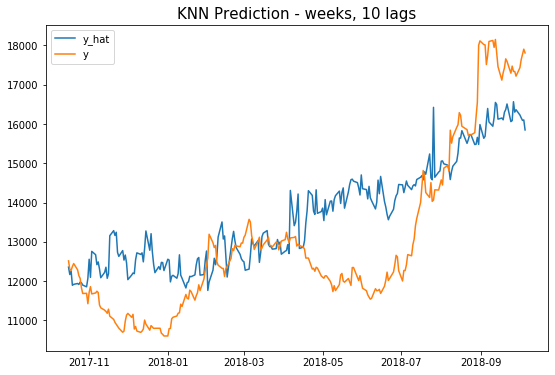

{}


In [51]:
from sklearn import neighbors

LME_shifted = LME.shift(-261).dropna()


cv_results = {}

K = 15
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

print()
print('K: ', K)

regressor.fit(X_train, y_train)
#print(regressor.coef_)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index


print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
#cv_results[str(K)] = mae

    # To find the best/optimal parameters


    
plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN Prediction - weeks, 10 lags', fontsize=15)

plt.show()

print(cv_results)

MAE for scaled results:  23.605086458162084

Mean Absolute Error: 1247.6971612380794
Mean Squared Error: 3283786.279096674
Root Mean Squared Error: 1812.122037583748
Polynomial MAE of Degree = 3:  1247.6971612380794


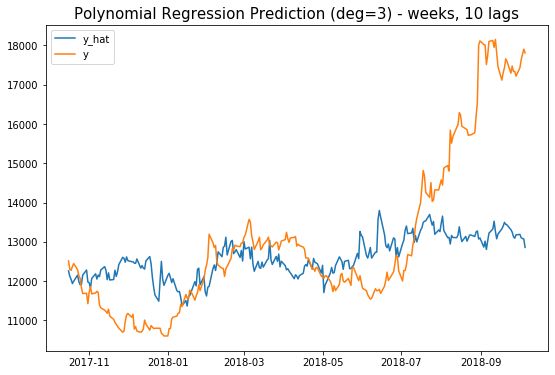

In [28]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item+rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item+rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index




print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 3: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression Prediction (deg=3) - weeks, 10 lags', fontsize=15)

plt.show()


MAE for scaled results:  15.608390318117403

Mean Absolute Error: 1317.9359784686258
Mean Squared Error: 2639006.174999626
Root Mean Squared Error: 1624.5018236369037
Polynomial MAE of Degree = 2:  1317.9359784686258


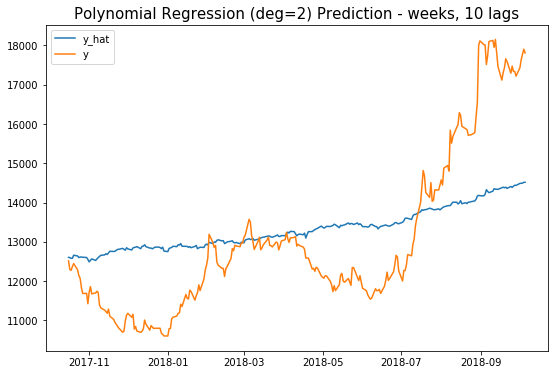

In [162]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=2)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index



print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 2: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression (deg=2) Prediction - weeks, 10 lags', fontsize=15)

plt.show()


MAE for scaled results:  23.691529257229476

Mean Absolute Error: 1852.1800236520023
Mean Squared Error: 4191197.8866774235
Root Mean Squared Error: 2047.241531104091
Polynomial MAE of Degree = 2:  1852.1800236520023


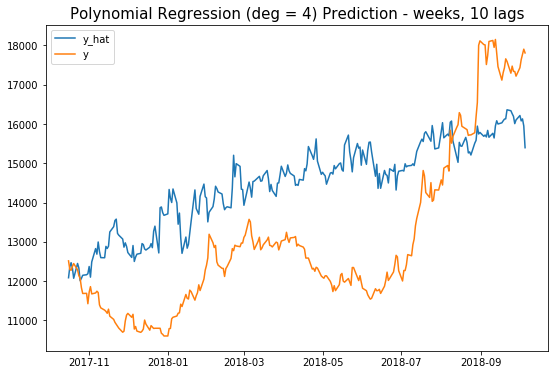

In [114]:
polynomial_features= PolynomialFeatures(degree=4)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

mae = np.sqrt(metrics.mean_absolute_error(y_test,y_poly_pred))
print('MAE for scaled results: ', mae)
print()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_poly_pred.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    unscaled_result = item + rolling_avg
    original_tail = original_tail.append(pd.Series([unscaled_result]))

unscaled = pd.Series(original_tail)
unscaled = unscaled[window_setting:]
unscaled.index = y_test.index


original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

for key, item in y_test.items():
    rolling_avg = original_tail.tail(window_setting).mean()
    original_y = item + rolling_avg
    original_tail = original_tail.append(pd.Series([original_y]))


original_y = pd.Series(original_tail)
original_y = original_y[window_setting:]
original_y.index = y_test.index


print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))


mae = metrics.mean_absolute_error(original_y, unscaled)
print('Polynomial MAE of Degree = 2: ', mae)
#print('kfold test accuracy =', kfold_test_accuracy)

# To find the best/optimal parameters


plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression (deg = 4) Prediction - weeks, 10 lags', fontsize=15)

plt.show()


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725


In [97]:
pd.DataFrame({'mean':tester.rolling(window=3).mean(), 'original': tester})

,mean,original
0,NaN,1.0
1,NaN,2.0
2,2.000000,3.0
3,3.000000,4.0
4,6.000000,11.0
5,7.000000,6.0
6,8.000000,7.0
7,7.000000,8.0
8,8.000000,9.0
9,5.833333,0.5
